In [1]:
import pathlib

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import ipywidgets as widgets

In [2]:
tmp_fig_dir = pathlib.Path('./figs/')
tmp_fig_dir.mkdir(exist_ok=True)
paper_fig_dir = pathlib.Path('../figs/')

In [3]:
df = pd.read_pickle('patching_data.pkl')
df.head()

,prompt,answer,objects,prompt_tokens,prompt_str_tokens,clean_prob,corrupted_prob,act_patch,reverse_act_patch
0,Voldemort's actual name was Tom Marvolo,R,"[Voldemort's, Tom Marvolo]","[[0, 55, 744, 358, 430, 434, 4588, 1416, 369, ...","[<|endoftext|>, V, old, em, ort, 's, actual, ...",0.961298,0.000352,"[[-0.00025124205, 0.0013499489, -0.0001343167,...","[[0.9999999, 0.9943583, 0.9829641, 0.9931691, ..."
1,"When Harry Potter went back to class, he saw t...",We,"[ Harry Potter, Hermione Granger]","[[0, 3039, 11643, 28753, 2427, 896, 281, 966, ...","[<|endoftext|>, When, Harry, Potter, went, ...",0.976687,0.001637,"[[0.0024199204, 0.0014548677, 0.016717227, 0.0...","[[1.0000023, 1.0000023, 0.951611, 0.96038353, ..."
2,"J.K. Rowling is the author of the book series """,Harry,[J.K. Rowling],"[[0, 43, 15, 44, 15, 15784, 1981, 310, 253, 24...","[<|endoftext|>, J, ., K, ., Row, ling, is, ...",0.953377,0.000780,"[[-0.0005425212, -0.00025214395, -0.0005322025...","[[1.0000006, 0.9462252, 0.9415986, 0.9583951, ..."
3,Harry Potter studies at the wizarding school n...,Hog,[Harry Potter],"[[0, 33244, 28753, 2175, 387, 253, 259, 478, 1...","[<|endoftext|>, Harry, Potter, studies, at,...",0.350461,0.027536,"[[0.08487414, 0.5551957, 0.16567747, 0.3670400...","[[0.99999815, 0.35405305, 0.66945136, 0.999998..."
4,Some of the most popular novels about wizards ...,Harry,[ wizards],"[[0, 6080, 273, 253, 954, 4633, 19204, 670, 25...","[<|endoftext|>, Some, of, the, most, popul...",0.422437,0.005146,"[[-0.0060291, -0.0011453568, 0.001441625, 0.00...","[[0.99999464, 0.99999464, 0.99999464, 0.999994..."


In [ ]:
def generate_patching_plot(row_num: int):
    row = df.iloc[row_num]
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    tokens = row['prompt_tokens']
    layers = np.arange(row['act_patch'].shape[0])
    tok_pos = np.arange(tokens.ravel().shape[0])
    yy, xx = np.meshgrid(layers, tok_pos)

    plot = ax1.pcolormesh(xx, yy, row['act_patch'].T, vmin=0, vmax=1, cmap='Blues', snap=True, rasterized=True)
    cb1 = plt.colorbar(plot, orientation='horizontal', location='top')


    plot = ax2.pcolormesh(xx, yy, row['reverse_act_patch'].T, vmin=0, vmax=1, cmap='Reds_r', snap=True, rasterized=True)
    cb2 = plt.colorbar(plot, orientation='horizontal', location='top')

    for ax in [ax1, ax2]:
        ax.set_ylim(layers.size-0.5, -0.5)
        ax.set_ylabel('layer')
        ax.set_yticks(layers[::5] - 0.5)
        ax.set_yticklabels(layers[::5])
        ax.set_xticks(tok_pos)
        ax.set_xticklabels([f"({i}) {row['prompt_str_tokens'][i]}" for i in tok_pos], rotation=90)
        ax.grid(axis='y')
        for i in tok_pos[1:]:
            ax.axvline(i-0.5, color='grey', linewidth=0.5)

    for cb in [cb1, cb2]:
        cb.ax.text(0.5, -0.15, 'Fraction of probability recovered', ha='center', va='top', transform=cb.ax.transAxes)
    plt.suptitle(f'prompt index {row_num}; Interfered tokens: {row["objects"]}')
    fig.savefig(tmp_fig_dir/f'patching_{row_num}.png', bbox_inches='tight', dpi=200)

for i in tqdm(range(df.shape[0])):
    generate_patching_plot(i)

In [5]:
nice_examples = [2, 4, 6, 8, 11, 22, 28, 32, 35, 37, 42, 46, 51, 58, 64, 65, 69, 70, 71, 72, ] #20 picked-by-hand examples

harder_good_examples = [5, 9, 10, 12, 14, 15, 17, 21, 23, 25, 26, 27, 34, 39, 40, 44, 49, 50, 52, 53, 56, 61, 63, 67, 73, 75]

complex_good_examples = [13, 38, 45, 48, 68]

### Token positions of interest on the good examples

In [6]:
last_obj_position = [6, 9, 3, 8, 17, 9, 9, 6, 6, 13, 9, 16, 10, 5, 7, 14, 4, 5, 3, 14]

# generate_patching_plot(nice_examples[len(last_obj_position)]) #was great for adding one at a time!

### Plots of the good examples

In [ ]:
for i in tqdm(range(len(nice_examples))):
    # print('example ', nice_examples[i])
    generate_patching_plot(nice_examples[i])

### Mean over the good examples on last_obj and on last_token

In [11]:
# TODO

act_patches = []
act_patches_r = []
for i, idx in enumerate(nice_examples):
    row = df.iloc[idx]
    #index out last object position and last position
    act_patches.append(row['act_patch'][:,[last_obj_position[i], -1]])
    act_patches_r.append(row['reverse_act_patch'][:,[last_obj_position[i], -1]])
act_patches = np.array(act_patches).mean(axis=0)
act_patches_r = np.array(act_patches_r).mean(axis=0)

In [32]:
for i in range(act_patches.shape[0]):
    print(i, act_patches[i] > 2/3, act_patches_r[i] < 1/3)

0 [False False] [ True False]
1 [False False] [ True False]
2 [False False] [ True False]
3 [False False] [ True False]
4 [ True False] [ True False]
5 [ True False] [ True False]
6 [ True False] [ True False]
7 [ True False] [ True False]
8 [ True False] [ True False]
9 [ True False] [ True False]
10 [ True False] [ True False]
11 [ True False] [ True False]
12 [ True False] [ True False]
13 [ True False] [ True False]
14 [ True False] [ True False]
15 [False False] [False False]
16 [False False] [False False]
17 [False False] [False False]
18 [False False] [False  True]
19 [False  True] [False  True]
20 [False  True] [False  True]
21 [False  True] [False  True]
22 [False  True] [False  True]
23 [False  True] [False  True]
24 [False  True] [False  True]
25 [False  True] [False  True]
26 [False  True] [False  True]
27 [False  True] [False  True]
28 [False  True] [False  True]
29 [False  True] [False  True]
30 [False  True] [False  True]
31 [False  True] [False  True]


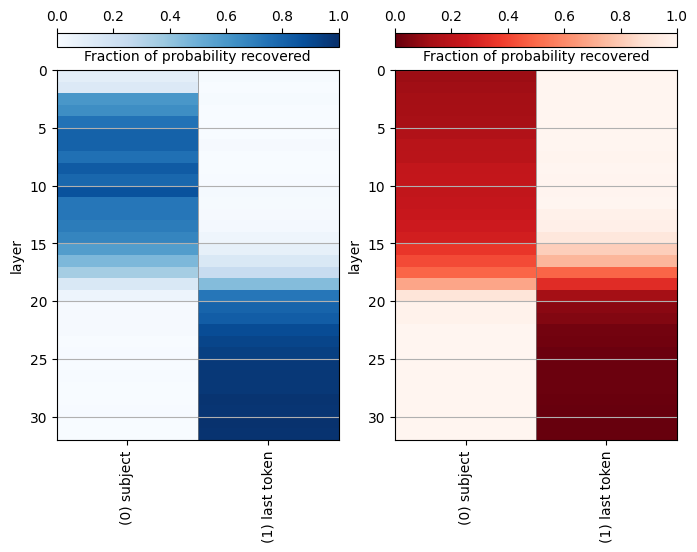

In [20]:
def generate_mean_plot():
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    tokens = ['subject', 'last token']
    layers = np.arange(row['act_patch'].shape[0])
    tok_pos = np.arange(2)
    yy, xx = np.meshgrid(layers, tok_pos)

    plot = ax1.pcolormesh(xx, yy, act_patches.T, vmin=0, vmax=1, cmap='Blues', snap=True, rasterized=True)
    cb1 = plt.colorbar(plot, orientation='horizontal', location='top')


    plot = ax2.pcolormesh(xx, yy, act_patches_r.T, vmin=0, vmax=1, cmap='Reds_r', snap=True, rasterized=True)
    cb2 = plt.colorbar(plot, orientation='horizontal', location='top')

    for ax in [ax1, ax2]:
        ax.set_ylim(layers.size-0.5, -0.5)
        ax.set_ylabel('layer')
        ax.set_yticks(layers[::5] - 0.5)
        ax.set_yticklabels(layers[::5])
        ax.set_xticks(tok_pos)
        ax.set_xticklabels([f"({i}) {tokens[i]}" for i in tok_pos], rotation=90)
        ax.grid(axis='y')
        for i in tok_pos[1:]:
            ax.axvline(i-0.5, color='grey', linewidth=0.5)

    for cb in [cb1, cb2]:
        cb.ax.text(0.5, -0.15, 'Fraction of probability recovered', ha='center', va='top', transform=cb.ax.transAxes)
    fig.savefig(tmp_fig_dir/f'mean_patching.png', bbox_inches='tight', dpi=200)
generate_mean_plot()